## Dataset Information

Suppose you are the product manager of a microchip factory, and you are in charge of the quality assurance (QA). During QA, each microchip goes through two tests. From the two test results, you would like to determine whether the microchips should be accepted, rejected or undecided (require more tests). To help you make the decision, you have a dataset of test results on past microchips, from which you can build classifiers for your future decisions. 

## Model Building: Gaussian Naive Bayes

### Objective 1:
Build a logistic regression classifier for the first two classes rejected and accepted

### Objective 2:
Build a Gaussian naïve Bayes classifier for the first two classes rejected and accepted. Thereafter, compare this classifier with the above logistic regression classifier, and determine if the Gaussian naïve Bayes classifier is worse or better than the above logistic regression classifier, and why.

### Objective 3:
Determine how to improve the classifier with the worst performance.

### Objective 4: 
Report the precision score, recall score and F1 score of the logistic regression classifier from objective 1. In this case, determine if all three scores have improved or declined from binary classification to 3-class classification. 

## Objective 1

### 1.0 Loading Packages and Reading Dataset

In [10]:
# Loading Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing, metrics, linear_model, naive_bayes

# Reading Dataset
data = np.loadtxt('microchip3.txt', delimiter = ',')

class ListTable(list):       
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

### 1.1 Data Summary

Once we have read our dataset, we want to perform some basic data exploration to get a glimpse of our dataset.

The steps taken for our basic data exploration consist of the following:
1. Getting a summary of the first five rows of our dataset for all variables; and
2. Checking for missing values in our dataset

#### 1.1.1 Getting a summary of the first five rows of our dataset for all variables:

In [11]:
pd.DataFrame(data).head(5)

,0,1,2
0,0.051267,0.69956,1.0
1,-0.092742,0.68494,1.0
2,-0.213710,0.69225,1.0
3,-0.375000,0.50219,1.0
4,-0.513250,0.46564,1.0


#### 1.1.2 Checking for missing values in our dataset (where missing value is indicated as '?')

In [12]:
pd_data = pd.DataFrame(data)

num_row, num_col = pd_data.shape

missing_value_count_row = {}
for i in range(num_row):
    value_count = pd_data.iloc[i,:].value_counts()
    missing_count = 0
    if '?' in value_count:
        missing_count = value_count['?']
    if missing_count in missing_value_count_row:
        missing_value_count_row[missing_count].append(i)
    else:
        missing_value_count_row[missing_count] = [i]

for missing_count, row_list in missing_value_count_row.items():
    print('there are', missing_count * len(row_list), 'missing values in', len(row_list), 'out of', num_row, 'rows.')
    
missing_value_count_col = {}
for j in range(num_col):
    value_count = pd_data.iloc[:,j].value_counts()
    missing_count = 0
    if '?' in value_count:
        missing_count = value_count['?']
    if missing_count in missing_value_count_col:
        missing_value_count_col[missing_count].append(j)
    else:
        missing_value_count_col[missing_count] = [j]

for missing_count, col_list in missing_value_count_col.items():
    print('there are', missing_count * len(col_list), 'missing values in', len(col_list), 'out of', num_col, 'columns.')

there are 0 missing values in 148 out of 148 rows.
there are 0 missing values in 3 out of 3 columns.


#### 1.1.3 Checking for missing values in our dataset (where missing value is indicated as 'NaN')

In [13]:
pd_data_null = []

for i in range(num_col):
    null_values = [[pd_data.iloc[:, i].isnull().sum()]]
    for results in null_values:
        pd_data_null.append(results)

pd.DataFrame(np.transpose(pd_data_null), columns = pd_data.columns, index = ["Number of Missing Value(s)"])

,0,1,2
Number of Missing Value(s),0,0,0


### 1.2 Basic Insights from Data Summary: 

Based on our preliminary data exploration above, we can see that there are no missing values in the dataset. Therefore, we can proceeed to the following steps prior to building our models:
1. Setting x and y variables
2. Visualizing Test Results from Past Microchips
2. Splitting Train and Test Dataset

### 1.3 Setting x and y variables

In [14]:
x = data[:,:2]
y = data[:,2].astype(int)

### 1.4 Visualizing Test Results from Past Microchips

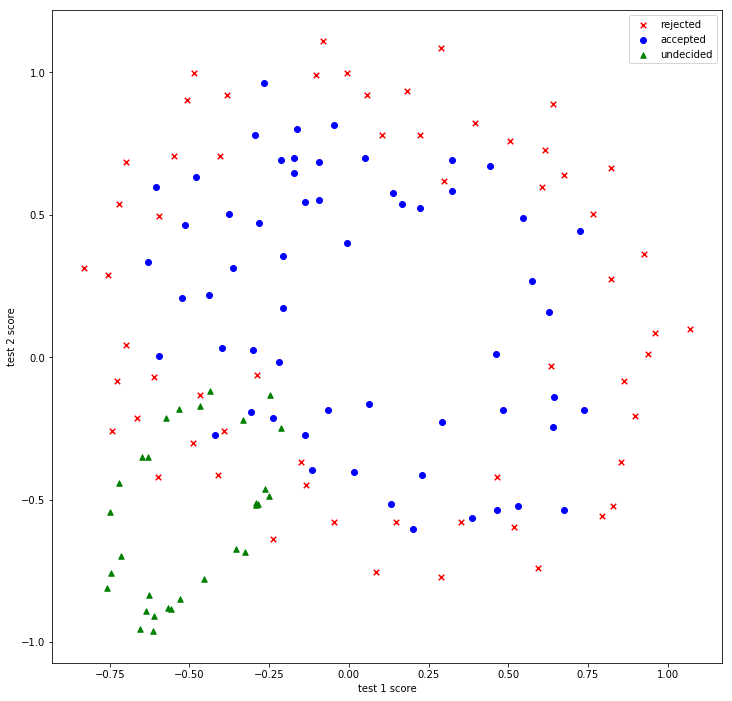

In [20]:
color = ['red', 'blue', 'green']
plt.figure(figsize = (12, 12))
plt.xlabel('test 1 score')
plt.ylabel('test 2 score')
plt.scatter(x[y==0,0], x[y==0,1], c=color[0], marker='x', s=30)
plt.scatter(x[y==1,0], x[y==1,1], c=color[1])
plt.scatter(x[y==2,0], x[y==2,1], c=color[2], marker='^', s=30)
plt.legend(('rejected', 'accepted', 'undecided'))
plt.show()

### 1.5 Splitting Train and Test Datasets

In [21]:
np.random.seed(2018)
train = np.random.choice([True, False], x.shape[0], replace=True, p=[0.6, 0.4])

x_train, y_train = x[train, :], y[train]
x_test, y_test = x[~train, :], y[~train]

x2_train, y2_train = x[np.logical_and(train, y<2),:], y[np.logical_and(train, y<2)]
x2_test, y2_test = x[np.logical_and(~train, y<2),:], y[np.logical_and(~train, y<2)]

### 1.6 Building a Logistic Regression Classifier for the First Two Classes: Rejected and Accepted

Upon completion of the data exploration and data pre-processing above, we are now interested in building a Logistic Regression Classifier for the first two classes, Rejected and Accepted, to see how it performs. However, prior to building the Logistic Regression Classifier, we have to first determine the best parameter, C, to be chosen.

#### 1.6.1 Visualizing Decision Boundary with Trade-off Parameter C = 1, C = 2, C = 3 and C = 4

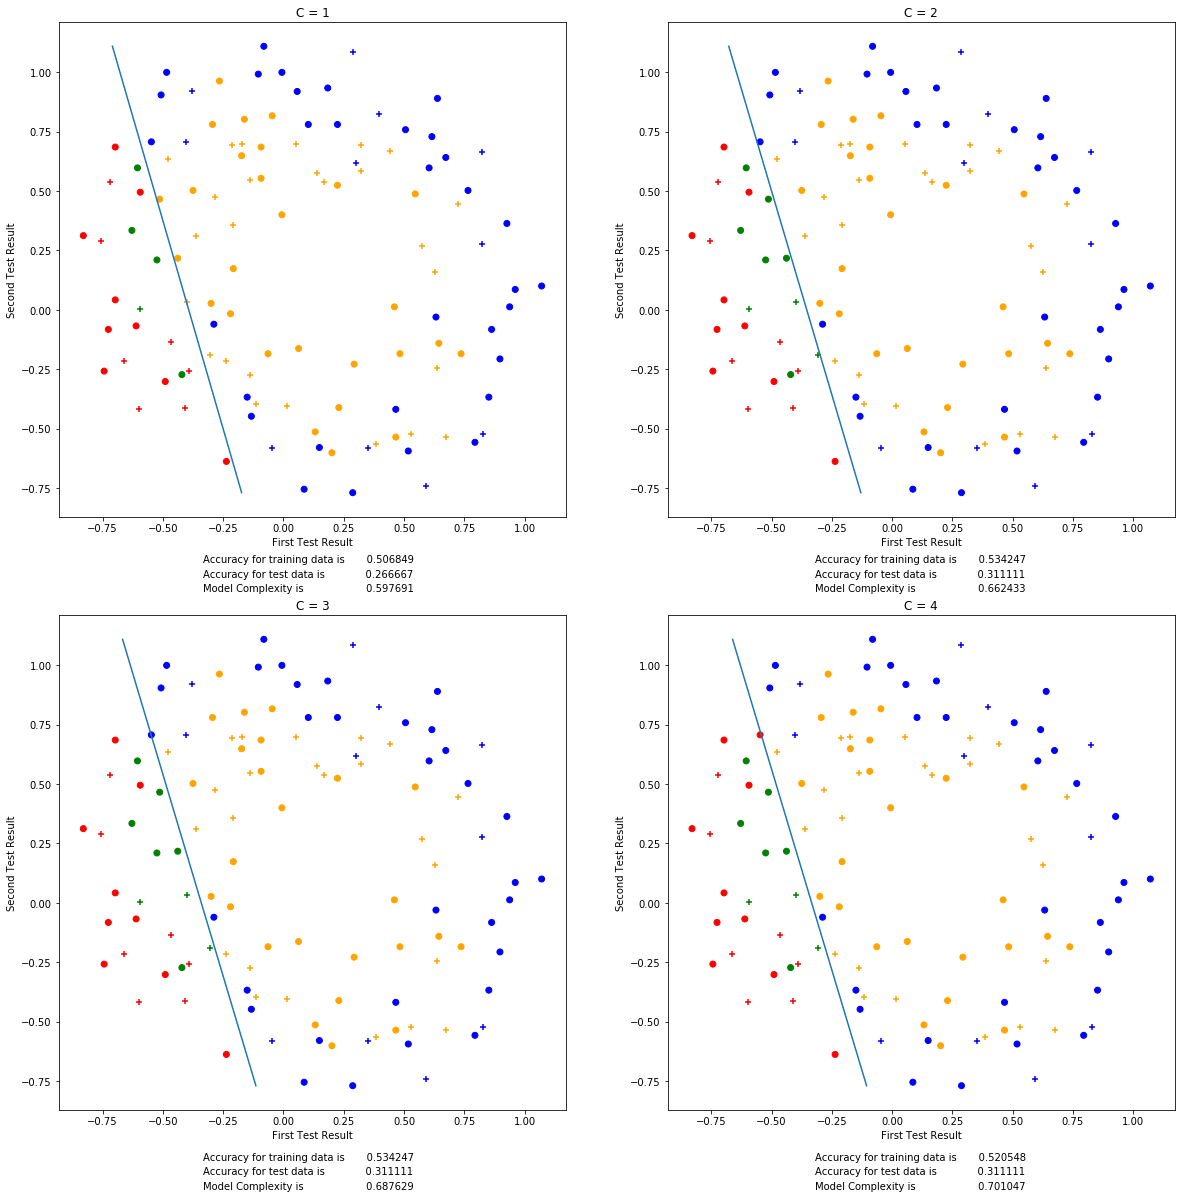

In [22]:
plt.figure(figsize = (20,20))
C = [1, 2, 3, 4]
for i in range(4):
    plt.subplot(2, 2, i+1)
    logit = linear_model.LogisticRegression(C=C[i])
    logit.fit(x2_train, y2_train)
    y2_train_pred = logit.predict(x2_train)
    y2_test_pred = logit.predict(x2_test)
    color = [['blue', 'red'], ['orange', 'green']]
    plt.scatter(data[np.logical_and(train, y<2),0], data[np.logical_and(train, y<2),1], c=[color[j1][j2] for j1, j2 in zip(y2_train, y2_train_pred)], marker='o')
    plt.scatter(data[np.logical_and(~train, y<2),0], data[np.logical_and(~train, y<2),1], c=[color[j1][j2] for j1, j2 in zip(y2_test, y2_test_pred)], marker='+')
    plt.plot((- logit.coef_[0][1] * np.array((min(data[np.logical_and(train, y<2),1]), max(data[np.logical_and(train, y<2),1]))) - logit.intercept_[0]) / logit.coef_[0][0], np.array((min(data[np.logical_and(train, y<2),1]), max(data[np.logical_and(train, y<2),1]))))
    plt.xlabel("First Test Result")
    plt.ylabel("Second Test Result")
    if i == 0:
        plt.title("C = 1")
        plt.figtext(0.225, 0.505, 'Accuracy for training data is       %f' % (metrics.accuracy_score(y2_train, y2_train_pred)))
        plt.figtext(0.225, 0.495, 'Accuracy for test data is             %f' % (metrics.accuracy_score(y2_test, y2_test_pred)))
        plt.figtext(0.225, 0.485, 'Model Complexity is                    %f' % (np.sqrt(np.square(logit.coef_[0][0]) + np.square(logit.coef_[0][1]))))
    if i == 1:
        plt.title("C = 2")
        plt.figtext(0.65, 0.505, 'Accuracy for training data is       %f' % (metrics.accuracy_score(y2_train, y2_train_pred)))
        plt.figtext(0.65, 0.495, 'Accuracy for test data is             %f' % (metrics.accuracy_score(y2_test, y2_test_pred)))
        plt.figtext(0.65, 0.485, 'Model Complexity is                    %f' % (np.sqrt(np.square(logit.coef_[0][0]) + np.square(logit.coef_[0][1]))))
    if i == 2:
        plt.title("C = 3")
        plt.figtext(0.225, 0.09, 'Accuracy for training data is       %f' % (metrics.accuracy_score(y2_train, y2_train_pred)))
        plt.figtext(0.225, 0.08, 'Accuracy for test data is             %f' % (metrics.accuracy_score(y2_test, y2_test_pred)))
        plt.figtext(0.225, 0.07, 'Model Complexity is                    %f' % (np.sqrt(np.square(logit.coef_[0][0]) + np.square(logit.coef_[0][1]))))
    if i == 3:
        plt.title("C = 4")
        plt.figtext(0.65, 0.09, 'Accuracy for training data is       %f' % (metrics.accuracy_score(y2_train, y2_train_pred)))
        plt.figtext(0.65, 0.08, 'Accuracy for test data is             %f' % (metrics.accuracy_score(y2_test, y2_test_pred)))
        plt.figtext(0.65, 0.07, 'Model Complexity is                    %f' % (np.sqrt(np.square(logit.coef_[0][0]) + np.square(logit.coef_[0][1]))))
plt.show()

#### 1.6.2 Choosing the Best Trade-off Parameter C

Based on the plot above, we can see that when trade-off parameter C is set at 2 and 3, the accuracy for training data and the accuracy for test data are the same at 0.534 and 0.311 respectively, and are higher than when parameter C is set at C = 1 or C = 4. However, when comparing parameter C = 2 and C = 3, the model complexity of parameter C = 3 is higher, at 0.688, than that of parameter C = 2, at 0.662.

Therefore, in this case, parameter C = 2 is the best parameter to be chosen.

Having chosen our parameter C, we will now proceed to evaluate the performance of our logistic regression classifier at parameter C = 2.

#### 1.6.3 Logistic Regression Classifier's Confusion Matrix

Once we have built our logistic regression classifier at parameter C = 2, we want to first take a look at the classification results in the confusion matrix as follow: 

In [23]:
logit = linear_model.LogisticRegression(C = 2)
logit.fit(x2_train, y2_train)

y2_logit_pred = logit.predict(x2_test)
confusion_mat = metrics.confusion_matrix(y2_test, y2_logit_pred)

confusion_mat_ind = np.asarray([["Actual Class = Rejected"],
                    ["Actual Class = Accepted"]])

confusion_mat_disp = np.hstack((confusion_mat_ind, confusion_mat))

table = ListTable()
table.append(["", "Predicted Class = Rejected", "Predicted Class = Accepted"])
for i in range(2):
    table.append(confusion_mat_disp[i])

table

,Predicted Class = Rejected,Predicted Class = Accepted
Actual Class = Rejected,11,7
Actual Class = Accepted,24,3


#### 1.6.4 Logistic Regression Classifier's Performance Metrics

Based on the confusion matrix table above, we will now evaluate the performance of our logistic regression classifier by reviewing the following metrics, and the reason for reviewing these metrics:

1. Accuracy Score
2. Precision Score
3. Recall Score
4. F1 Score

##### Accuracy Score
We are interested in evaluating how correct our classifier is in classifying the quality of the microchips as Accepted or Rejected.

##### Precision Score
However, it is also important that we do not wrongly classify a faulty microchip as a non-faulty microchip. As a product manager in charge of QA of the microchips, I would be concerned if a faulty microchip is wrongly classified as a non-faulty microchip, as there is a higher cost associated with false positives when performing quality assurance checks. 

##### Recall Score
However, we are not only interested in evaluating how accurate our classifier is, but also how correct we are in classifying a non-faulty microchip as a non-faulty microchip and not as a faulty microchip, as it would result in wastage as well as a loss in potential revenue that could have been earned if these non-faulty microchips were sold. Therefore, this can be evaluated by measuring the recall rate of our classifier.

##### F1 Score
Therefore, with the assumption that Precision Score is as important as the Recall Score, we want to evaluate our classifer by measuring the F1 Score. F1 Score is calculated by obtaining the harmonic mean of both Recall Score and Precision Score.

#### 1.6.5 Evaluating Logistic Regression Classifier's Performance

In [24]:
print('Accuracy Score:  ', metrics.accuracy_score(y2_test, y2_logit_pred), "\n")
print('Precision Score: ', metrics.precision_score(y2_test, y2_logit_pred), "\n")
print('Recall Score:    ', metrics.recall_score(y2_test, y2_logit_pred), "\n")
print('F1 Score:        ', metrics.f1_score(y2_test, y2_logit_pred))

Accuracy Score:   0.3111111111111111 

Precision Score:  0.3 

Recall Score:     0.1111111111111111 

F1 Score:         0.16216216216216217


### 1.7 Discussion on Performance of Logistic Regression Classifier

#### 1.7.1 Preliminary Discussion on Performance of Logistic Regression Classifier

##### Accuracy Score
Based on the results obtained above, we can see that the Logistic Regression Classifier is a poor performer. The classifier was only able to accurately identify the two classes at a rate of approximately 31%. 

##### Precision Score
The Precision Score, which measures the rate at which the classifier does not wrongly classify a faulty microchip as a non-faulty microchip, fared poorly at 30%. 

##### Recall Score
The Recall Score, which measures the rate at which the classifier does not wrongly classify a non-faulty microchip as a faulty microchip, fared even worse at a rate of approximately 11%. 

##### F1 Score
Lastly, the F1 Score, which attempts to balance the Precision Score and the Recall Score, fared badly at only approximately 16% as well.

##### Visualizing Probabilistic Contours of Logistic Regression Classifier
To further understand the reason for the poor performance, we will visualize the probabilistic contours of the classifier for the two classes - Rejected and Accepted.

#### 1.7.2 Visualizing Probabilistic Contours of Logistic Regression Classifier for the First Two Classes: Rejected and Accepted

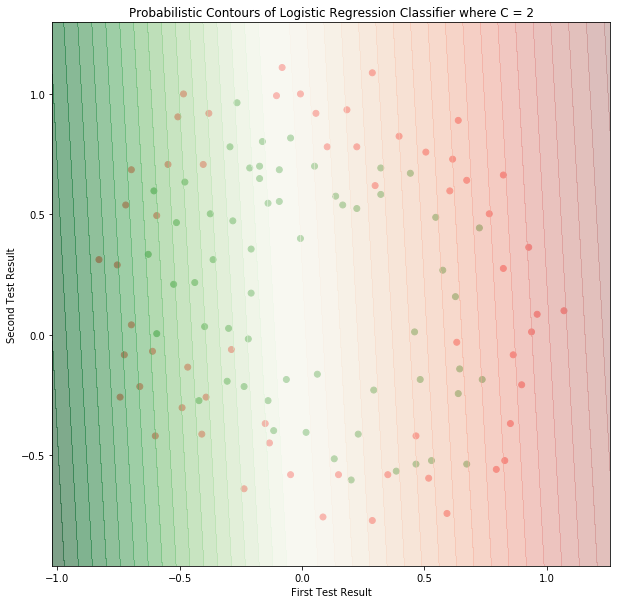

In [25]:
data_2class = data[data[:,2] <2]

x_2class = data_2class[:,:2]
y_2class = data_2class[:,2].astype(int)

logit = linear_model.LogisticRegression(C = 2)
logit.fit(x_2class, y_2class)

def my_linspace (min_value, max_value, steps):
    diff = max_value - min_value
    return np.linspace (min_value - 0.1 * diff, max_value + 0.1 * diff, steps)

steps = 200
x0 = my_linspace(min(x_2class[:,0]), max(x_2class[:,0]), steps)
x1 = my_linspace(min(x_2class[:,1]), max(x_2class[:,1]), steps)
xx0, xx1 = np.meshgrid(x0, x1)
mesh_data = np.c_[xx0.ravel(), xx1.ravel()]
mesh_proba = logit.predict_proba(mesh_data).reshape(steps, steps, 2)
  
color = ['red', 'green']
y_color = [color[i] for i in y_2class]
contour_color = [plt.cm.Reds, plt.cm.Greens]
plt.figure(figsize = (10, 10))
plt.scatter(x_2class[:,0], x_2class[:,1], c=y_color)
    
for i in range(2):
    plt.contourf(xx0, xx1, np.maximum(mesh_proba[:,:,i], 0.5), 20, cmap=contour_color[i], alpha=0.5)

plt.title('Probabilistic Contours of Logistic Regression Classifier where C = 2')
plt.xlabel("First Test Result")
plt.ylabel("Second Test Result")
plt.show()

#### 1.7.3 Final Discussion on Performance of Logistic Regression Classifier

As visualized on the probabilistic contours of Logistic Regression Classifier above, we can see that the two classes are distributed in an elliptical manner, with the first class label forming in an inner circle, and the second class label forming in the outer circle, surrounding the first class label.

In two-class classification, the Logistic Regression Classifier calculates the odds of microchips being Rejected or Accepted based on the sigmoid function f(x) = (1 / e^-x +1). The logarithm of the function is taken to create a continuous variable of the odds, which is given by the linear equation (w^Tx+b). Since the Logistic Regression Classifier attempts to separate the two classes via a linear decision boundary, it fares poorly in separating both class labels effectively, since both class labels are not linearly separable.

## Objective Two

### 2.0 Building a Naive Bayes Classifier for the First Two Classes: Rejected and Accepted

#### 2.0.1 Naive Bayes Classifier's Confusion Matrix
Next, we will build a Naive Bayes Classifier and to evaluate its classification result in the confusion matrix as follow:

In [26]:
gnb = naive_bayes.GaussianNB()
gnb.fit(x2_train, y2_train)

y2_gnb_pred = gnb.predict(x2_test)
confusion_mat = metrics.confusion_matrix(y2_test, y2_gnb_pred)

confusion_mat_ind = np.asarray([["Actual Class = Rejected"],
                    ["Actual Class = Accepted"]])

confusion_mat_disp = np.hstack((confusion_mat_ind, confusion_mat))

table = ListTable()
table.append(["", "Predicted Class = Rejected", "Predicted Class = Accepted"])
for i in range(2):
    table.append(confusion_mat_disp[i])

table

,Predicted Class = Rejected,Predicted Class = Accepted
Actual Class = Rejected,14,4
Actual Class = Accepted,10,17


#### 2.0.2 Evaluating Logistic Regression Classifier's Performance

In [27]:
print('Accuracy Score:  ', metrics.accuracy_score(y2_test, y2_gnb_pred), "\n")
print('Precision Score: ', metrics.precision_score(y2_test, y2_gnb_pred), "\n")
print('Recall Score:    ', metrics.recall_score(y2_test, y2_gnb_pred), "\n")
print('F1 Score:        ', metrics.f1_score(y2_test, y2_gnb_pred))

Accuracy Score:   0.6888888888888889 

Precision Score:  0.8095238095238095 

Recall Score:     0.6296296296296297 

F1 Score:         0.7083333333333334


### 2.1 Discussion on Performance of Gaussian Naive Bayes Classifier Versus Performance of Logistic Regression Classifier

#### 2.1.1 Preliminary Discussion on Performance of Gaussian Naive Bayes Classifier versus Performance of Logistic Regression Classifier

##### Comparison of Accuracy Score
Based on the results obtained above, we can see that the Gaussian Naive Bayes (GNB) Classifier is a better performer. The GNB classifier was able to accurately identify the two classes at a rate of approximately 69%, which was 38% higher than that of the Logistic Regression Classifier. 

##### Comparison of Precision Score
The Precision Score, which measures the rate at which the classifier does not wrongly classify a faulty microchip as a non-faulty microchip, fared well at approximately 81%, which was 51% higher than that of the Logistic Regression Classifier. 

##### Comparison of Recall Score
The Recall Score, which measures the rate at which the classifier does not wrongly classify a non-faulty microchip as a faulty microchip, fared approximately well at a rate of approximately 63%, which was 52% higher than that of the Logistic Regression Classifier. 

##### Comparison of F1 Score
Lastly, the F1 Score, which attempts to balance the Precision Score and the Recall Score, fared moderately well at approximately 71%, which was 55% higher than that of the Logistic Regression Classifier.

##### Visualizing Probabilistic Contours of Logistic Regression Classifier and GNB Classifier
To further understand the reason why GNB Classifier performs better than the Logistic Regression Classifier, we will visualize the probabilistic contours of both classifiers for the two classes - Rejected and Accepted.

#### 2.1.2 Visualizing Probabilistic Contours of Logistic Regression Classifier and GNB Classifier for the First Two Classes: Rejected and Accepted

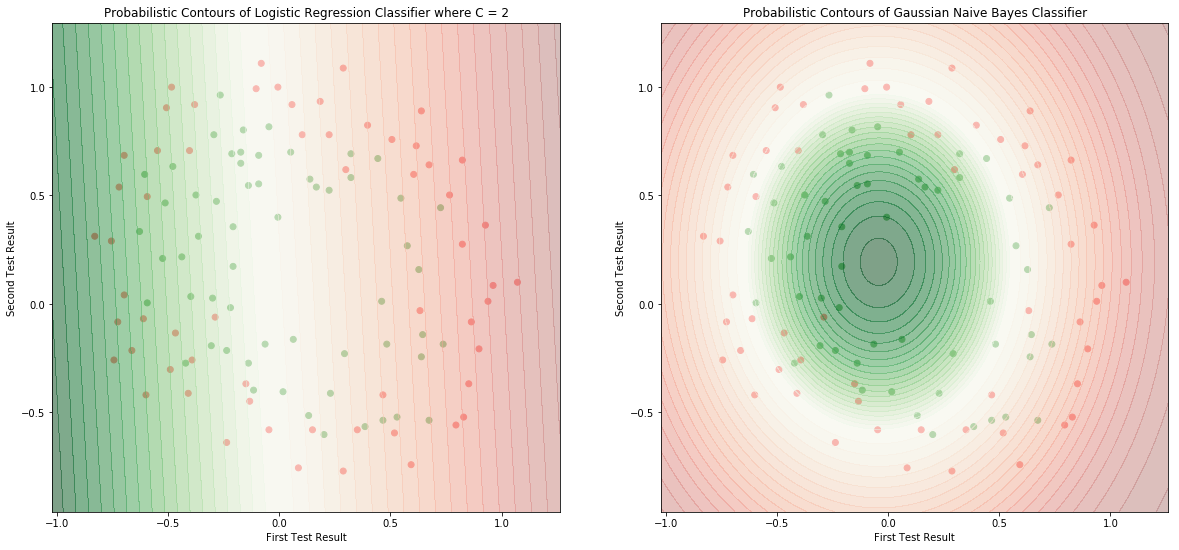

In [28]:
data_2class = data[data[:,2] <2]

x_2class = data_2class[:,:2]
y_2class = data_2class[:,2].astype(int)

logit = linear_model.LogisticRegression(C = 2)
logit.fit(x_2class, y_2class)

gnb = naive_bayes.GaussianNB()
gnb.fit(x_2class, y_2class)

def my_linspace (min_value, max_value, steps):
    diff = max_value - min_value
    return np.linspace (min_value - 0.1 * diff, max_value + 0.1 * diff, steps)

steps = 200
x0 = my_linspace(min(x_2class[:,0]), max(x_2class[:,0]), steps)
x1 = my_linspace(min(x_2class[:,1]), max(x_2class[:,1]), steps)
xx0, xx1 = np.meshgrid(x0, x1)
mesh_data = np.c_[xx0.ravel(), xx1.ravel()]
logit_mesh_proba = logit.predict_proba(mesh_data).reshape(steps, steps, 2)
gnb_mesh_proba = gnb.predict_proba(mesh_data).reshape(steps, steps, 2)

color = ['red', 'green']
y_color = [color[i] for i in y_2class]
contour_color = [plt.cm.Reds, plt.cm.Greens]

plt.figure(figsize = (20, 9))

plt.subplot(121)
plt.title('Probabilistic Contours of Logistic Regression Classifier where C = 2')
plt.xlabel("First Test Result")
plt.ylabel("Second Test Result")
plt.scatter(x_2class[:,0], x_2class[:,1], c=y_color) 
for i in range(2):
    plt.contourf(xx0, xx1, np.maximum(logit_mesh_proba[:,:,i], 0.5), 20, cmap=contour_color[i], alpha=0.5) 

plt.subplot(122)
plt.title('Probabilistic Contours of Gaussian Naive Bayes Classifier')
plt.xlabel("First Test Result")
plt.ylabel("Second Test Result")
plt.scatter(x_2class[:,0], x_2class[:,1], c=y_color)
for i in range(2):
    plt.contourf(xx0, xx1, np.maximum(gnb_mesh_proba[:,:,i], 0.5), 20, cmap=contour_color[i], alpha=0.5) 

plt.show()

#### 2.1.3 Final Discussion on Performance of Logistic Regression Classifier

As visualized on the probabilistic contours of both Logistic Regression Classifier and Gaussian Naive Bayes Classifier above, we can see that the two classes are distributed in an elliptical manner.

In two-class classification, the Logistic Regression Classifier calculates the odds of microchips being Rejected or Accepted based on the sigmoid function f(x) = (1 / e^-x +1). The logarithm of the function is taken to create a continuous variable of the odds, which is given by the linear equation (w^Tx+b). Since the Logistic Regression Classifier attempts to separate the two classes via a linear decision boundary, it fares poorly in separating both class labels effectively, since both class labels are not linearly separable.

On the other hand, the Gaussian Naive Bayes Classifier has the equation p(Ck|x) proportionate to p(x|Ck)p(Ck) and assumes that each of the two class labels, represented by Ck, is distributed based on the Gaussian / Normal Distribution Model. The probability of each instance x in the dataset is then calculated based on the density function for class Ck, p(x|Ck), which is parameterized by the mean and variance in each class. In this case, the rejected microchips has a wider variance from the mean than that of the accepted microchips. Therefore, the Gaussian Naive Bayes Classifier is a better performer as it creates a decision boundary that separates the two classes based on a non-linear, elliptical manner. As a result, the Gaussian Naive Bayes Classifier is a better performer than that of the Logistic Regression Classifier.

## Objective Three

### 3.0 Improving Performance of Logistic Regression Classifier

Based on the results obtained above, we can see that the worst performing classifier is the Logistic Regression Classifier. 

In order to improve the Logistic Regression Classifier, we can attempt to map the data to a higher-dimensional space, where polynomial mapping can be performed via the PolynomialFeatures from the sklearn package. If an input sample of features is two dimensional in the form of [a, b] (which is the case from our dataset, where we have two test results), and we attempt to map the features into a degree-2 polynomial features, we will obtain a 6-dimensional vector in the form of [1, a, b, a^2, ab, b^2]. 

Polynomial mapping thus allows our Logistic Regression Classifier to separate the two classes via a linear decision boundary within a higher-dimensional space, allowing it more flexibility to fit a wider range of data.

However, the curse of dimensionality is that a small input sample of features mapped to a higher-dimensional space would result in an exponential increase of features. In the event that there are too many features, it increases the complexity of the classifier. Though the learned hypothesis may allow the training data to be fitted very well in the classifier, it would most likely result in overfitting, where the classifier may fail to generalize to any new observations / data (test data). Therefore, it would be necessary to introduce regularization in our Logistic Regression Classifier to overcome this issue.

Correspondingly, the following refer to the Logistic Regression Sigmoid Function, Regularized Cost Function and Gradient of the Cost Function:

##### 1. Sigmoid Function:
htheta(x) = g(x*theta)

##### 2. Regularized Cost Function:
( ((-(y*log(htheta(x))) - ((1-y)*log(1-(htheta(x))))) * (1/n) ) + ( (lambda/2)*sum(theta[1:]^2)) ) * (1/n) )

##### 3. Gradient of Cost Function:
(((htheta(x)-y)*x) + (lambda * theta[1:])) * (1/n)

##### Visualization of Polynomial Mapping and Regularized Logistic Regression Performance
In this case, we will visualize the performance of Regularized Logistic Regression Classifiers with different levels of regularization parameter, lambda, on degree-2, degree-4 and degree-6 polynomial features of our dataset.

#### 3.0.1 Visualization of Polynomial Mapping and Logistic Regression Regularization

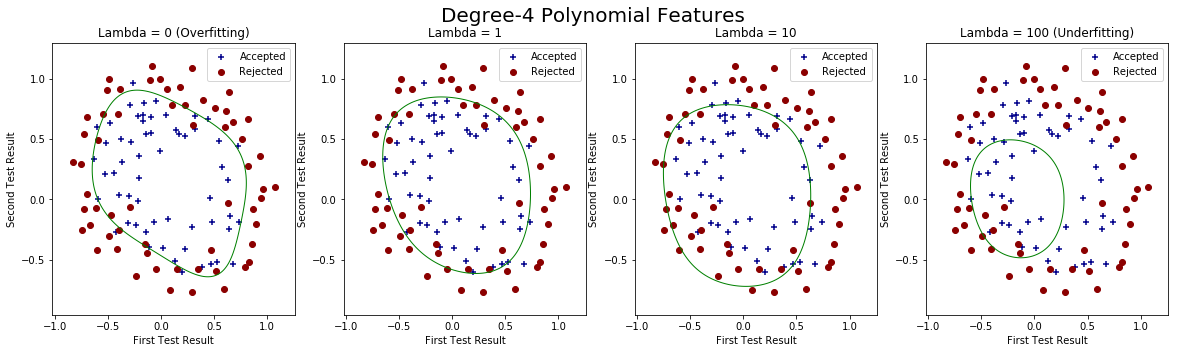

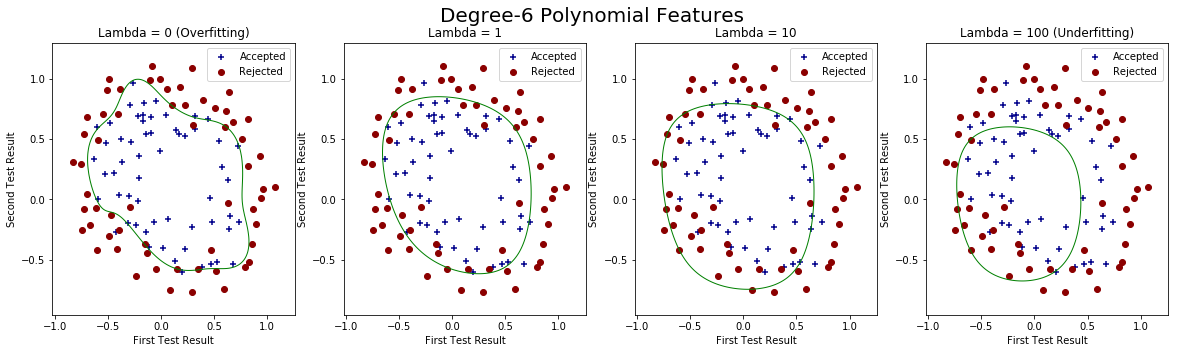

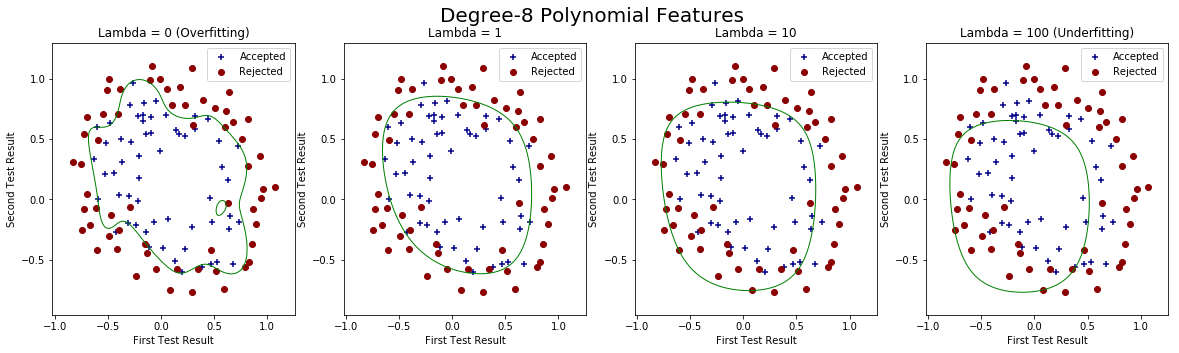

In [29]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import fmin_bfgs
import warnings
warnings.simplefilter("ignore")

poly4 = PolynomialFeatures(4)
x_poly4 = poly4.fit_transform(x_2class)
num_rows4, num_cols4 = x_poly4.shape
theta_4 = np.zeros(num_cols4)

poly6 = PolynomialFeatures(6)
x_poly6 = poly6.fit_transform(x_2class)
num_rows6, num_cols6 = x_poly6.shape
theta_6 = np.zeros(num_cols6)

poly8 = PolynomialFeatures(8)
x_poly8 = poly8.fit_transform(x_2class)
num_rows8, num_cols8 = x_poly8.shape
theta_8 = np.zeros(num_cols8)

def sigmoid(X):
    g = (1.0) / (1 + np.e**-X)
    return g

def costfunc(theta, X, Y, L):
    n = len(X)
    htheta = sigmoid(np.dot(X, theta))
    cost = (( -(np.dot(Y,np.log(htheta))) - (np.dot((1-Y),np.log(1-htheta))) ) * (1/n)) + (( (L/2)*(np.sum(np.square(theta[1:]))) ) * (1/n))
    return cost
    
def gradcostfunc(theta, X, Y, L):
    n = len(X)
    htheta = sigmoid(np.dot(X, theta))
    thetazero = np.insert(theta[1:], 0, 0) 
    grad = ((np.dot((htheta-Y),X))+(L*thetazero)) * (1/n)
    return grad

def my_linspace (min_value, max_value, steps):
    diff = max_value - min_value
    return np.linspace (min_value - 0.1 * diff, max_value + 0.1 * diff, steps)

fig_deg4 = plt.figure(figsize = (20, 5))
fig_deg4.suptitle('Degree-4 Polynomial Features', fontsize=20)
for i, L in enumerate([0, 1, 10, 100]):
    mincost = fmin_bfgs(f = costfunc, x0 = theta_4, args=(x_poly4, y_2class, L), fprime = gradcostfunc, maxiter = 400, disp = False)
    
    plt.subplot(1,4,i+1)
    plt.scatter(x_poly4[:, 1:3][y_2class==1, 0], x_poly4[:,1:3][y_2class==1, 1], c='darkblue', marker='+', label="Accepted")
    plt.scatter(x_poly4[:, 1:3][y_2class==0, 0], x_poly4[:,1:3][y_2class==0, 1], c='darkred', marker='o', label="Rejected")
    
    steps = 200
    x0 = my_linspace(min(x_poly4[:,1]), max(x_poly4[:,1]), steps)
    x1 = my_linspace(min(x_poly4[:,2]), max(x_poly4[:,2]), steps)
    xx0, xx1 = np.meshgrid(x0, x1)
    mesh_data = np.c_[xx0.ravel(), xx1.ravel()]
    boundary = sigmoid(poly4.fit_transform(mesh_data).dot(mincost)).reshape(xx0.shape)
    plt.contour(xx0, xx1, boundary, [0.5], linewidths = 1, colors = 'g')
    
    plt.xlabel("First Test Result")
    plt.ylabel("Second Test Result")
    plt.legend(loc='upper right', frameon=True)
    
    if i == 0:
        plt.title("Lambda = 0 (Overfitting)")
    if i == 1:
        plt.title("Lambda = 1")
    if i == 2:
        plt.title("Lambda = 10")
    if i == 3:
        plt.title("Lambda = 100 (Underfitting)")

fig_deg6 = plt.figure(figsize = (20, 5))
fig_deg6.suptitle('Degree-6 Polynomial Features', fontsize=20)
for i, L in enumerate([0, 1, 10, 100]):
    mincost = fmin_bfgs(f = costfunc, x0 = theta_6, args=(x_poly6, y_2class, L), fprime = gradcostfunc, maxiter = 400, disp = False)
    
    plt.subplot(1,4, i+1)
    plt.scatter(x_poly6[:, 1:3][y_2class==1, 0], x_poly6[:,1:3][y_2class==1, 1], c='darkblue', marker='+', label="Accepted")
    plt.scatter(x_poly6[:, 1:3][y_2class==0, 0], x_poly6[:,1:3][y_2class==0, 1], c='darkred', marker='o', label="Rejected")

    steps = 200
    x0 = my_linspace(min(x_poly6[:,1]), max(x_poly6[:,1]), steps)
    x1 = my_linspace(min(x_poly6[:,2]), max(x_poly6[:,2]), steps)
    xx0, xx1 = np.meshgrid(x0, x1)
    mesh_data = np.c_[xx0.ravel(), xx1.ravel()]
    boundary = sigmoid(poly6.fit_transform(mesh_data).dot(mincost)).reshape(xx0.shape)
    plt.contour(xx0, xx1, boundary, [0.5], linewidths = 1, colors = 'g')
    
    plt.xlabel("First Test Result")
    plt.ylabel("Second Test Result")
    plt.legend(loc='upper right', frameon=True)
    
    if i == 0:
        plt.title("Lambda = 0 (Overfitting)")
    if i == 1:
        plt.title("Lambda = 1")
    if i == 2:
        plt.title("Lambda = 10")
    if i == 3:
        plt.title("Lambda = 100 (Underfitting)")    

fig_deg8 = plt.figure(figsize = (20, 5))
fig_deg8.suptitle('Degree-8 Polynomial Features', fontsize=20)
for i, L in enumerate([0, 1, 10, 100]):
    mincost = fmin_bfgs(f = costfunc, x0 = theta_8, args=(x_poly8, y_2class, L), fprime = gradcostfunc, maxiter = 400, disp = False)
    
    plt.subplot(1,4,i+1)
    plt.scatter(x_poly8[:, 1:3][y_2class==1, 0], x_poly8[:,1:3][y_2class==1, 1], c='darkblue', marker='+', label="Accepted")
    plt.scatter(x_poly8[:, 1:3][y_2class==0, 0], x_poly8[:,1:3][y_2class==0, 1], c='darkred', marker='o', label="Rejected")
    
    steps = 200
    x0 = my_linspace(min(x_poly8[:,1]), max(x_poly8[:,1]), steps)
    x1 = my_linspace(min(x_poly8[:,2]), max(x_poly8[:,2]), steps)
    xx0, xx1 = np.meshgrid(x0, x1)
    mesh_data = np.c_[xx0.ravel(), xx1.ravel()]
    boundary = sigmoid(poly8.fit_transform(mesh_data).dot(mincost)).reshape(xx0.shape)
    plt.contour(xx0, xx1, boundary, [0.5], linewidths = 1, colors = 'g')
    
    plt.xlabel("First Test Result")
    plt.ylabel("Second Test Result")
    plt.legend(loc='upper right', frameon=True)
    
    if i == 0:
        plt.title("Lambda = 0 (Overfitting)")
    if i == 1:
        plt.title("Lambda = 1")
    if i == 2:
        plt.title("Lambda = 10")
    if i == 3:
        plt.title("Lambda = 100 (Underfitting)")  
        
plt.show()

### 3.1 Discussion on Improvement of Logistic Regression Classifier

Based on the plot above, we can see that as the degree of polynomial features increases, the better fit the datapoints will be to the Classifier. However, we can also note that without regularization (where Lambda = 0), the Classifier will tend to overfit.

## Objective Four

### 4.0  Precision Score, Recall Score and F1 Score of Logistic Regression Classifier From Part One

Before we build our Multi-Class Logistic Regression Model Using the Softmax Function, we want to first print the Precision Score, Recall Score, and F1 Score that we have obtained from Part One above.

In [30]:
print('Precision Score: ', metrics.precision_score(y2_test, y2_logit_pred), "\n")
print('Recall Score:    ', metrics.recall_score(y2_test, y2_logit_pred), "\n")
print('F1 Score:        ', metrics.f1_score(y2_test, y2_logit_pred))

Precision Score:  0.3 

Recall Score:     0.1111111111111111 

F1 Score:         0.16216216216216217


### 4.1 Building a Multi-Class Logistic Regression Model Using Softmax Function

Based on the Precision Score, Recall Score and F1 Score we have obtained from Part One above, we want to now build our Multi-Class Logisitic Regression Model and calculate its Precision Score, Recall Score and F1 Score to determine if the scores obtained from multi-class classification have improved from binary classification.

In [31]:
logit_softmax = linear_model.LogisticRegression(C = 2, multi_class = 'multinomial', solver = 'newton-cg')
logit_softmax.fit(x_train, y_train)

y_pred = logit_softmax.predict(x_test)

#### 4.1.1 Precision Score, Recall Score and F1 Score of Multi-Class Logistic Regression Model

In [32]:
print('Precision Score: ', metrics.precision_score(y_test, y_pred, average = "weighted"), "\n")
print('Recall Score:    ', metrics.recall_score(y_test, y_pred, average = "weighted"), "\n")
print('F1 Score:        ', metrics.f1_score(y_test, y_pred, average = "weighted"))

Precision Score:  0.40168918918918917 

Recall Score:     0.4166666666666667 

F1 Score:         0.3714285714285714


At first glance, we are able to observe the following:

1. It seems as though all three scores obtained from multi-class classification have improved from binary classification. However, this might not be true and further investigation is required.

2. Additionally, since F1 score is the harmonic mean of precision and recall, it should fall between the precision and recall score. However, this is not what we observe from the above. From the above, we can see that the F1 Score is 0.371, which is lower than that of both Precision Score of 0.402 and Recall Score of 0.417.

Therefore, in order to investigate further, we have to first take a look at the confusion matrix table for the multi-class Logistic Regression Model.

#### 4.1.2 Confusion Matrix of Multi-Class Logistic Regression Model

In [362]:
confusion_mat = metrics.confusion_matrix(y_test, y_pred)

confusion_mat_ind = np.asarray([["Actual Class = Rejected"],
                                ["Actual Class = Accepted"],
                                ["Actual Class = Undecided"]])

confusion_mat_disp = np.hstack((confusion_mat_ind, confusion_mat))

table = ListTable()
table.append(["", "Predicted Class = Rejected", "Predicted Class = Accepted", "Predicted Class = Undecided"])
for i in range(3):
    table.append(confusion_mat_disp[i])

table

,Predicted Class = Rejected,Predicted Class = Accepted,Predicted Class = Undecided
Actual Class = Rejected,11,4,3
Actual Class = Accepted,25,2,0
Actual Class = Undecided,1,2,12


#### 4.1.3 Precision Score, Recall Score and F1 Score Based on Confusion Matrix of Multi-Class Logistic Regression Model

Based on the confusion matrix table obtained above, we would now like to manually calculate the Precision Score, Recall Score and F1 Score for each of the class label, without obtaining the weighted average of all three scores, based on the formula as indicated below:

#### Precision Score
##### Precision Score for Class Label = Rejected:
TP / (TP + FP) = 11 / (11 + 25 + 1)

##### Precision Score for Class Label = Accepted:
TP / (TP + FP) = 2 / (2 + 4 + 2)

##### Precision Score for Class Label = Undecided:
TP / (TP + FP) = 12 / (12 + 3 + 0)


#### Recall Score
##### Recall Score for Class Label = Rejected:
TP / (TP + FN) = 11 / (11 + 4 + 3)

##### Recall Score for Class Label = Accepted:
TP / (TP + FN) = 2 / (2 + 25 + 0)

##### Recall Score for Class Label = Undecided:
TP / (TP + FN) = 12 / (12 + 1 + 2)


#### F1 Score
##### F1 Score for Class Label = Rejected:
2 * (precision * recall) / (precision + recall) = 2 * (0.2972973 * 0.61111111) / (0.2972973 + 0.61111111)

##### F1 Score for Class Label = Accepted:
2 * (precision * recall) / (precision + recall) = 2 * (0.25 * 0.07407407) / (0.25 + 0.07407407)

##### F1 Score for Class Label = Undecided:
2 * (precision * recall) / (precision + recall) = 2 * (0.8 * 0.8) / (0.8 + 0.8)


#### 4.1.4 Manual Calculation of Precision Score Based on Confusion Matrix of Multi-Class Logistic Regression Model

In [363]:
print('Precision Score of Class Label = Rejected: ', 11 / (11 + 25 + 1), "\n")
print('Precision Score of Class Label = Accepted: ', 2 / (2 + 4 + 2), "\n")
print('Precision Score of Class Label = Undecided: ', 12 / (12 + 3 + 0))

Precision Score of Class Label = Rejected:  0.2972972972972973 

Precision Score of Class Label = Accepted:  0.25 

Precision Score of Class Label = Undecided:  0.8


#### 4.1.5 Manual Calculation of Recall Score Based on Confusion Matrix of Multi-Class Logistic Regression Model

In [364]:
print('Recall Score of Class Label = Rejected: ', 11 / (11 + 4 + 3), "\n")
print('Recall Score of Class Label = Accepted: ', 2 / (2 + 25 + 0), "\n")
print('Recall Score of Class Label = Undecided: ', 12 / (12 + 1 + 2))

Recall Score of Class Label = Rejected:  0.6111111111111112 

Recall Score of Class Label = Accepted:  0.07407407407407407 

Recall Score of Class Label = Undecided:  0.8


#### 4.1.6 Manual Calculation of F1 Score Based on Confusion Matrix of Multi-Class Logistic Regression Model

In [365]:
print('F1 Score of Class Label = Rejected: ', 2 * (0.2972973 * 0.61111111) / (0.2972973 + 0.61111111), "\n")
print('F1 Score of Class Label = Accepted: ', 2 * (0.25 * 0.07407407) / (0.25 + 0.07407407), "\n")
print('F1 Score of Class Label = Undecided: ', 2 * (0.8 * 0.8) / (0.8 + 0.8))

F1 Score of Class Label = Rejected:  0.4000000022082644 

F1 Score of Class Label = Accepted:  0.11428570943673465 

F1 Score of Class Label = Undecided:  0.8000000000000002


#### 4.1.7 Comparison of Binary Classification Scores Against Multi-Class Classification Scores

Thereafter, we will now compare the scores that we have obtained from Binary Classification in Part One against the newly calculated multi-class classification scores for each class label.

In [366]:
print('--------------- Binary Classification Scores for Class Label = Accepted ---------------')
print('Precision Score: ', metrics.precision_score(y2_test, y2_logit_pred))
print('Recall Score:    ', metrics.recall_score(y2_test, y2_logit_pred))
print('F1 Score:        ', metrics.f1_score(y2_test, y2_logit_pred),"\n")

print('--------------- Multi-Class Classification Precision Scores ---------------')
print('Precision Score of Class Label = Rejected: ', 11 / (11 + 25 + 1))
print('Precision Score of Class Label = Accepted: ', 2 / (2 + 4 + 2))
print('Precision Score of Class Label = Undecided: ', 12 / (12 + 3 + 0), "\n")

print('--------------- Multi-Class Classification Recall Scores ---------------')
print('Recall Score of Class Label = Rejected: ', 11 / (11 + 4 + 3))
print('Recall Score of Class Label = Accepted: ', 2 / (2 + 25 + 0))
print('Recall Score of Class Label = Undecided: ', 12 / (12 + 1 + 2), "\n")

print('--------------- Multi-Class Classification F1 Scores ---------------')
print('F1 Score of Class Label = Rejected: ', 2 * (0.2972973 * 0.61111111) / (0.2972973 + 0.61111111))
print('F1 Score of Class Label = Accepted: ', 2 * (0.25 * 0.07407407) / (0.25 + 0.07407407))
print('F1 Score of Class Label = Undecided: ', 2 * (0.8 * 0.8) / (0.8 + 0.8))

--------------- Binary Classification Scores for Class Label = Accepted ---------------
Precision Score:  0.3
Recall Score:     0.1111111111111111
F1 Score:         0.16216216216216217 

--------------- Multi-Class Classification Precision Scores ---------------
Precision Score of Class Label = Rejected:  0.2972972972972973
Precision Score of Class Label = Accepted:  0.25
Precision Score of Class Label = Undecided:  0.8 

--------------- Multi-Class Classification Recall Scores ---------------
Recall Score of Class Label = Rejected:  0.6111111111111112
Recall Score of Class Label = Accepted:  0.07407407407407407
Recall Score of Class Label = Undecided:  0.8 

--------------- Multi-Class Classification F1 Scores ---------------
F1 Score of Class Label = Rejected:  0.4000000022082644
F1 Score of Class Label = Accepted:  0.11428570943673465
F1 Score of Class Label = Undecided:  0.8000000000000002


#### 4.1.8 Discussion on Comparison of Binary Classification Scores Against Multi-Class Classification Scores

##### Discussion on Comparison of Precision Score
We can see that when comparing the multi-class classification Precision Scores against the Binary Classification Precision Score, both class label = "Rejected" and "Accepted" performed poorer in multi-class classification, at 0.297 and 0.25, than the binary classification, at 0.3. 

However, the precision score of class label = "Undecided" performed well with a score of 0.8.

##### Discussion on Comparison of Recall Score
When comparing the multi-class classification Recall Score against the Binary Classification Recall Score, class label = "Rejected" performed much better in multi-class classification, at 0.611, than the binary classification, at 0.111. 

For class label = "Accepted", the multi-class classification recall score performed worse with a score of 0.074 as compared to the binary classification recall score at 0.111.

For class label = "Undecided" on the other hand, performed best with a score of 0.8.

##### Discussion on Comparison of F1 Score
Further, we can see that when comparing the multi-class classification F1 Score against the Binary Classification Recall Score, class label = "Rejected" performed much better in multi-class classification, at 0.4, than the binary classification, at 0.162.

For class label = "Accepted", the multi-class classification F1 score performed worse with a score of 0.114 as compared to the binary classification F1 score at 0.162.

For class label = "Undecided" on the other hand, performed best with a score of 0.8.

#### 4.1.9 Discussion on Reason Why F1 Score Observed Did Not Fall Between Precision and Recall Score

From the above, where we have calculated the individual precision, recall and F1 scores for each of the class labels for the multi-class classification, we can see that the F1 score for each of the class labels do indeed fall in between the Precision and Recall Score of each class label.

For example, the F1 score of the Rejected class was 0.4, which lies between its Precision Score and Recall Score of 0.297 and 0.611 respectively. The same is also true for the Accepted class and the Undecided class that their F1 score falls between their respective Precision and Recall Scores. 

When we were using weighted average to calculate each of the scores above, the F1 score obtained did not fall between the weighted average Precision and Recall Score. This occurred because the scores were calculated based on their average weighted by support, which is the number of true instances for each label, which can be seen below:

##### Weighted Average Precision Score of Three Class Labels:
(Rejected Precision Score * Number of true Rejected / Total Number of observations +
Accepted Precision Score * Number of true Accepted / Total Number of observations + 
Undecided Precision Score * Number of true Undecided / Total Number of observations) 

In [53]:
print("The weighted average precision score for all three class labels is:", 0.2972972972972973*18/60 + 0.25*27/60 + 0.8*15/60, "\n")

The weighted average precision score for all three class labels is: 0.4016891891891892 



##### Weighted Average Recall Score of Three Class Labels:
(Rejected Recall Score * Number of true Rejected / Total Number of observations + 
Accepted Recall Score * Number of true Accepted / Total Number of observations + 
Undecided Recall Score * Number of true Undecided / Total Number of observations) 

In [54]:
print("The weighted average recall score for all three class labels is:", 0.6111111111111112*18/60 + 0.07407407407407407*27/60 + 0.8*15/60, "\n")

The weighted average recall score for all three class labels is: 0.41666666666666663 



##### Weighted Average F1 Score of Three Class Labels:
(Rejected F1 Score * Number of true Rejected / Total Number of observations + 
Accepted F1 Score * Number of true Accepted / Total Number of observations + 
Undecided F1 Score * Number of true Undecided / Total Number of observations) 

In [55]:
print("The weighted average recall score for all three class labels is:", 0.4000000022082644*18/60 + 0.11428570943673465*27/60 + 0.8000000000000002*15/60, "\n")

The weighted average recall score for all three class labels is: 0.37142856990900996 



### 4.2 Conclusion on Comparison of Binary Classification Score Against Multi-Class Classification Scores and Reason for F1 Score Observed Not Falling Between the Precision and Recall Scores As Expected

#### Reason for F1 Score Observed Not Falling Between the Precision and Recall Scores As Expected
We will first conclude on the reason why F1 score observed not falling between the Precision and Recall scores as expected. Based on the calculations above, we can see that as the sklearn packages calculate the weighted average scores of each class label based on the number of true instances over the total number of instances, it has thus led to the F1 score to seemingly be scored below the Precision and Recall Scores. 

However, when we calculate the Precision, Recall and F1 scores for each class label individually, we can observe that the F1 score for each class label actually do fall between their respective Precision and Recall Scores. Additionally, by manually calculating the weighted average scores of all class labels based on the proportion of each class label's true instances, we can see that the results do indeed equal to the scores calculated by the sklearn package, where the weighted average F1 score was below the weighted average Precision and Recall scores.

#### Comparison of Binary Classification Score Against Multi-Class Classification Scores
Next, we will conclude on the comparison of Binary Classification Score Against the Multi-Class Classification Scores.

At first, when we compute the weighted average of all three Scores - Precision Score, Recall Score and F1 Score for multi-class classification, it seemed as though it has better performance than binary classification. However, due to the unbalanced number of labels in the dataset, the high Precision Score, Recall Score and F1 Score for class label = "Undecided" has overshadowed the poor performance of both class label = "Rejected" and "Accepted".

To summarise, the following detail the differences between the Scores obtained from Binary Classification and Multi-Class Classification for "Rejected" and "Accepted" Class Labels:

##### For Class Label = "Rejected"
1. Precision Score: Performed worse in Multi-Class Classification
2. Recall Score: Performed better in Multi-Class Classification
3. F1 Score: Performed better in Multi-Class Classification

##### For Class Label = "Accepted"
1. Precision Score: Performed worse in Multi-Class Classification
2. Recall Score: Performed worse in Multi-Class Classification
3. F1 Score: Performed worse in Multi-Class Classification

For Class Label = "Undecided", it performed well with a score of 0.8 for all three Precision, Recall and F1 Scores.

The F1 Scores, being the harmonic mean of both Precision and Recall Scores, of all three class labels fall between the Precision and Recall Scores of each class label as expected.

Next, we will attempt to visualize the Probabilistic Contours of Logistic Regression Classifier for all three class labels in order to understand the reason for the differences between the Scores obtained from Binary Classification and Multi-Class Classification for "Rejected" and "Accepted" Class Labels, as well as the well-performing Scores for the "Undecided" Class Label.

#### 4.2.1 Visualizing Probabilistic Contours of Logistic Regression Classifier for Three Class Labels

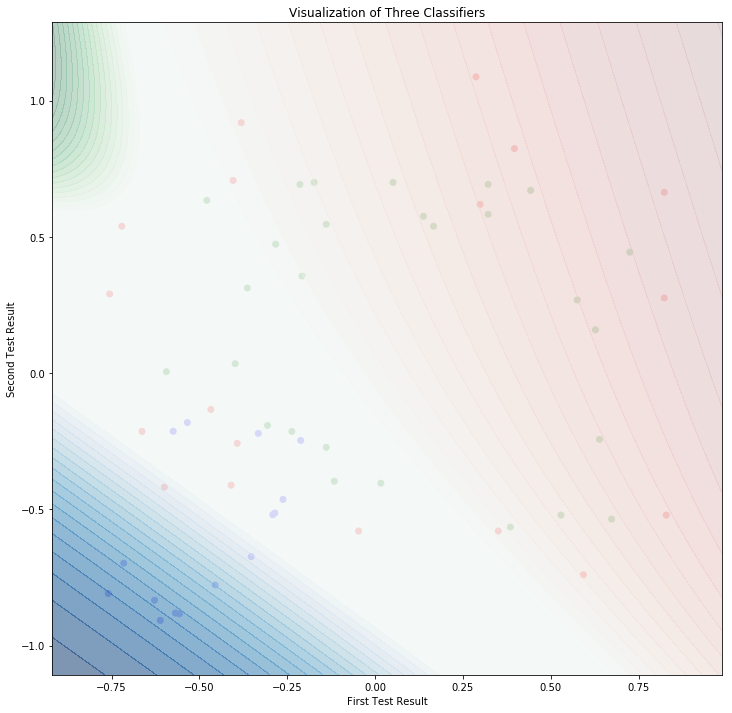

In [315]:
def my_linspace(min_value, max_value, steps):
    diff = max_value - min_value
    return np.linspace(min_value - 0.1 * diff, max_value + 0.1 * diff, steps)

steps = 200

x0 = my_linspace(min(x_test[:,0]), max(x_test[:,0]), steps)
x1 = my_linspace(min(x_test[:,1]), max(x_test[:,1]), steps)
xx0, xx1 = np.meshgrid(x0, x1)
mesh_data = np.c_[xx0.ravel(), xx1.ravel()]
mesh_proba = logit_softmax.predict_proba(mesh_data).reshape(steps, steps, 3)

color = ['red', 'green', 'blue']
y_color = [color[i] for i in y_test]

contour_color = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]
plt.figure(figsize=(12, 12))
plt.scatter(x_test[:,0], x_test[:,1], c=y_color)

for i in range(3):
    plt.contourf(xx0, xx1, np.maximum(mesh_proba[:,:,i], 0.5), 20, cmap=contour_color[i], alpha=0.5)


plt.xlabel("First Test Result")
plt.ylabel("Second Test Result")
plt.title("Visualization of Three Classifiers")
plt.show()

#### 4.2.2 Discussion on Probabilistic Contours of Logistic Regression Classifier for Three Class Labels

As visualized on the probabilistic contours of the Multi-Class Logistic Regression Classifier above, we can see that the data points for both "Accepted" and "Rejected" classes are distributed in an elliptical manner. On the other hand, the "Undecided" class is distributed in a cluster on the bottom left of the plot.

Softmax Regression, or Multi-Class Logistic Regression, is a generalization of Logistic Regression for multi-class classification, based on the assumption that all classes are mutually exclusive. Multi-Class Logistic Regression differs from the Binary Class Logistic Regression as it replaces the sigmoid logistic function of f(x) = (1 / e^-x +1) with the softmax function (e^xk / sum(e^xi)), where k represents the outcome. For each row, the probability of each outcome will be calculated which sums up to 1. Since all probabilities must equal to 1, the probability of one of the class label can be determined once the probabilities of the other k-1 class labels are known. Therefore, there are only k-1 separately specifiable probabilities, and hence k-1 separately identifiable vectors. Essentially, k-1 binary logistic regression models are built with one class label as the reference, and the probabilities of the other class labels are determined relative to the reference class label, which is the k-th class label. In this case, the k-th class label in our dataset is the "Undecided" Class Label. 

As visualized on the Probabilistic Contour Plot above, we can see that the decision boundary of the "Undecided" Class Label is able to better separate the "Undecided" data points, which thus led to a higher Precision, Recall and therefore F1 Score when predicting "Undecided" Class Label.

On the other hand, when compared with the Probabilitic Contours of the Logistic Regression Classifer for "Rejected" and "Accepted" Class Labels in Part One, both decision boundaries of "Rejected" and "Accepted" Class Labels for the above Probabilistic Contour of Multi-Class Logistic Regression Classifier are significantly reduced, and thus led to a decreased ability of the Multi-Class Classifier in properly separating and predicting the correct Class Labels. Therefore, as a result, the Precision Scores of both "Accepted" and "Rejected" Class Labels in the Multi-Class Logistic Regression Classifier are lower than that in the Binary Class Logistic Regression Classifier.

Additionally, the smaller decision boundary area of the "Accepted" Class Label led to a lesser data points being predicted as "Accepted" Class Labels. This can also be seen from the confusion matrix derived in section 2.4.1.2. above, where the total number of data points predicted as "Accepted" was only 8, out of the 60 total number of data points. Since the decision boundary of the "Accepted" Class Label is unable to sufficiently capture data points, it has led to most of the actual "Accepted" data points to be predicted as "Rejected" Class Label.